# Causal Analysis of Symmetric Facts
We analyze where facts might be locateed in an LLM. A fact is represented by a tuple of subject, relation, object (s,r,o). We also investigate where an inverse fact mis located. An inverse fact is represented by the tuple (o, r^-1, s). For example, the fact "Paris is the capital of France" has the inverse fact "France's capital is France". 

## Setup

In [1]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [2]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
Installing dependencies from lock file

Package operations: 0 installs, 3 updates, 0 removals

  • Updating importlib-metadata (6.7.0 -> 5.2.0)
  • Updating urllib3 (1.26.16 -> 2.0.3)
  • Updating p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
circuitsvis 1.40.0 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.


In [3]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer

In [4]:
# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [5]:
import ast
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.cm import ScalarMappable
import pickle

In [6]:
if IN_COLAB: 
    import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [7]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [8]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

def get_device(): 
    return "cuda" if cuda() else "cpu"

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load a pickle object from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj


device = get_device()
device

'cuda'

## Model

- fold_ln: Whether to fold in the LayerNorm weights to the subsequent linear layer. This does not change the computation.
- center_writing_weights: Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNormthis doesn't change the computation.
- center_unembed : Whether to center W_U (ie set mean to be zero). Softmax is translation invariant so this doesn't affect log probs or loss, but does change logits. Defaults to True.
- refactor_factored_attn_matrices: Whether to convert the factoredmatrices (W_Q & W_K, and W_O & W_V) to be "even". 

In [9]:
MODEL_NAME = "gpt2-large"

In [10]:
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    center_unembed=True,  
    center_writing_weights=True,              # Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNorm this doesn't change the computation.      
    fold_ln=True,                             # Whether to  fold in the LayerNorm weights to the subsequent linear layer.
    refactor_factored_attn_matrices=True,
)


 

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Dataset

In [11]:
import requests
import json

url = "https://rome.baulab.info/data/dsets/counterfact.json"

# Fetch the JSON data from the URL
response = requests.get(url)
dataset = response.json()


In [12]:
def sample_dataset(dataset, idx = None): 
    if idx is None: 
        prompt = "The {} is located in"
        subject = "Eiffel Tower"
        target = "Paris"
    else: 
        sample = dataset[idx]
        prompt = sample["requested_rewrite"]["prompt"]
        subject = sample["requested_rewrite"]["subject"]
        target = sample["requested_rewrite"]["target_true"]["str"]
    return prompt, subject, target

In [13]:
def noise_ablation(prompt, subject, target, n_noise_samples=5, vx=3):
    subject_tokens = model.to_tokens(subject)
    
    #shape: batch, n_tokens, embedding_dim
    subject_embedding = model.embed(subject_tokens)
    _, n_tokens, embedding_dim = subject_embedding.shape
    
    #noise: N(0,v), v = 3*std(embedding)
    embedding = model.W_E
    v = vx*torch.std(embedding, dim=0) #for each v in V
    noise = torch.randn(
        (n_noise_samples, n_tokens, embedding_dim)
    ).to(device) + v
    
    subject_embedding_w_noise = subject_embedding + noise
    
    #shape: batch, n_tokens, vocab_size (logits)
    unembedded_subject = model.unembed(subject_embedding_w_noise)

    noisy_subject_tokens = torch.argmax(unembedded_subject, dim=-1)
    noisy_subject_str = [
        model.to_string(nst) for nst in noisy_subject_tokens
    ]
    true_prompt = prompt.format(subject)
    corrupted_prompts = [
        prompt.format(nss) for nss in noisy_subject_str
    ]
    return true_prompt, corrupted_prompts, target

In [14]:
prompt, subject, target = sample_dataset(dataset)
noise_ablation(prompt, subject, target)

('The Eiffel Tower is located in',
 ['The rssLOADiuzarWave is located in',
  'The  Cachecox McDonnellril Daniels is located in',
  'The uer dynindallik Amin is located in',
  'The asseape Creed fouinkle is located in',
  'The  Roberts ed "$:/uraleous is located in'],
 'Paris')

In [15]:
def resample_ablation(prompt, subject, target, n_noise_samples=20):
    subject_tokens = model.to_tokens(subject)
    embedding = model.W_E
    #we select n random rows from the embedding matrix
    permutations = torch.randperm(embedding.size(0))[:n_noise_samples]
    random_samples = embedding[permutations]
    #unsqueeze a token dimension between batch and embedding dims
    random_samples = random_samples.unsqueeze(dim=1)
    #we de-embed these rows
    random_embeddings = model.unembed(random_samples)
    random_tokens = torch.argmax(random_embeddings, dim=-1)
    random_subject_str = [
        model.to_string(t) for t in random_tokens
    ]
    corrupted_facts = [
        prompt.format(s) for s in random_subject_str
    ]
    true_fact = prompt.format(subject)
    return true_fact, corrupted_facts, target
    

    
    

In [16]:
resample_ablation(prompt, subject, target, n_noise_samples=5)

('The Eiffel Tower is located in',
 ['The  onboard is located in',
  'The  sweating is located in',
  'The ipop is located in',
  'The  stating is located in',
  'The  description is located in'],
 'Paris')

In [17]:
def pad_from_left(tokens : torch.tensor, maxlen:int):
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros(tokens.shape[0], maxlen)
    
    n_pads = maxlen - tokens.shape[-1]
    padded_tokenized_inputs[:,n_pads] = pad_token
    padded_tokenized_inputs[:,n_pads:] = tokens
    return padded_tokenized_inputs.long()

def pad_to_same_length(clean_tokens, corrupted_tokens): 
    
    maxlen = max([clean_tokens.shape[-1], corrupted_tokens.shape[-1]])
    
    if clean_tokens.shape[-1] > corrupted_tokens.shape[-1]: 
        corrupted_tokens = pad_from_left(corrupted_tokens, maxlen)
    elif clean_tokens.shape[-1] < corrupted_tokens.shape[-1]: 
        clean_tokens = pad_from_left(clean_tokens, maxlen)
    return clean_tokens, corrupted_tokens

In [18]:

def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    cache):
    corrupted_residual_component[:, pos, :] = cache[hook.name][:, pos, :]
    """
    Restore a patch in clean run. 
    """
    return corrupted_residual_component
    
    
def total_effect_causal_tracing_w_ablation(
                             clean_prompt: str,
                             corrupted_prompts: List[str],
                             target: str, 
                             corrupted_ablation=True, 
                             run="all"):
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    target_token_idx = model.to_tokens(target)[:,1:] #remember to slice out the start pad token
        
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    
    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")

    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        #shape: noise_batch, n_tokens, vocab_size
        final_token_logits = clean_logits
    else: 
        final_token_logits = corrupted_logits
    
    #get the logits on the final token
    final_token_logits = final_token_logits[:,-1,:] #shape: batch, vocab_size
    #get the mean logit across the vocabulary
    u_pi = final_token_logits.mean(dim=1, keepdim=True)
    #get the logit for maximum likelihood token
    mle_token_idx = torch.argmax(final_token_logits, dim=-1).unsqueeze(-1)
    mle_token_logit = final_token_logits.gather(dim=-1, index=mle_token_idx)
    #also get the logit for the target token
    target_token_logit = final_token_logits.gather(dim=-1, index=target_token_idx)
    
    #center the logit for the target and mle tokens
    target_logit_centered_reference = target_token_logit - u_pi #shape: batch, n_tokens (generally=1)
    mle_logit_centered_reference = mle_token_logit - u_pi
    
        
    mle_total_effect_residuals = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    mle_total_effect_mlp = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    mle_total_effect_attn = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    target_total_effect_residuals = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    target_total_effect_mlp = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    target_total_effect_attn = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)

    if corrupted_ablation: 
        input_tokens = clean_tokens
        restore_cache = corrupted_cache
    else: 
        input_tokens = corrupted_tokens
        restore_cache = clean_cache
        
    for layer in range(model.cfg.n_layers):
        for position in range(clean_tokens.shape[-1]):
            #we do a clean run and get logit. We do a corrupted run and restore a clean 
            #activation. total effect is corrupted_logits_w_clean_patch - clean_logit. 
            #if the patch did not contribute, we get the original logits -> no effect
            
            if run=="residual" or run=="all":
                #Patch activations in the residual stream at token position and layer. 
                hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
                #shape: batch, n_tokens, vocab_size
                patched_logits = model.run_with_hooks(
                    input_tokens,
                    fwd_hooks = [(utils.get_act_name("resid_pre", layer),hook_fn)],
                    return_type="logits"
                )
                patched_logits = patched_logits[:,-1,:] #get logit of last token (shape: batch, vocab)
                u_pi = patched_logits.mean(dim=1, keepdim=True)
                mle_token_logit = patched_logits.gather(dim=-1, index=mle_token_idx)
                target_token_logit = patched_logits.gather(dim=-1, index=target_token_idx)
                target_logit_centered = target_token_logit - u_pi
                mle_logit_centered = mle_token_logit - u_pi

                resid_total_effect_on_target_logit = target_logit_centered - target_logit_centered_reference #batch x 1
                resid_total_effect_on_mle_logit = mle_logit_centered - mle_logit_centered_reference #batch x 1
                
                mle_total_effect_residuals[layer, position] = resid_total_effect_on_mle_logit.mean()
                target_total_effect_residuals[layer, position] = resid_total_effect_on_target_logit.mean()

            if run=="attn" or run== "all":
                #Patch activations in attention layers
                hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
                patched_logits = model.run_with_hooks(
                    input_tokens,
                    fwd_hooks = [(utils.get_act_name("attn_out", layer), hook_fn)],
                    return_type="logits"
                )
                patched_logits = patched_logits[:,-1,:] #get logit of last token (shape: batch, vocab)
                u_pi = patched_logits.mean(dim=1, keepdim=True)
                mle_token_logit = patched_logits.gather(dim=-1, index=mle_token_idx)
                target_token_logit = patched_logits.gather(dim=-1, index=target_token_idx)
                target_logit_centered = target_token_logit - u_pi
                mle_logit_centered = mle_token_logit - u_pi

                attn_total_effect_on_target_logit = target_logit_centered - target_logit_centered_reference #batch x 1
                attn_total_effect_on_mle_logit = mle_logit_centered - mle_logit_centered_reference #batch x 1
                
                mle_total_effect_attn[layer, position] = attn_total_effect_on_mle_logit.mean()
                target_total_effect_attn[layer, position] = attn_total_effect_on_target_logit.mean()
                
            if run=="mlp" or run=="all":
                #Patch activations in MLP layers
                hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
                patched_logits = model.run_with_hooks(
                    input_tokens,
                    fwd_hooks = [(utils.get_act_name("mlp_out", layer), hook_fn)],
                    return_type="logits"
                )
                patched_logits = patched_logits[:,-1,:] #get logit of last token (shape: batch, vocab)
                u_pi = patched_logits.mean(dim=1, keepdim=True)
                mle_token_logit = patched_logits.gather(dim=-1, index=mle_token_idx)
                target_token_logit = patched_logits.gather(dim=-1, index=target_token_idx)
                target_logit_centered = target_token_logit - u_pi
                mle_logit_centered = mle_token_logit - u_pi

                mlp_total_effect_on_target_logit = target_logit_centered - target_logit_centered_reference #batch x 1
                mlp_total_effect_on_mle_logit = mle_logit_centered - mle_logit_centered_reference #batch x 1
                
                mle_total_effect_mlp[layer, position] = mlp_total_effect_on_mle_logit.mean()
                target_total_effect_mlp[layer, position] = mlp_total_effect_on_target_logit.mean()


            
    return (
        mle_total_effect_residuals, 
        mle_total_effect_attn, 
        mle_total_effect_mlp, 
        target_total_effect_residuals, 
        target_total_effect_attn, 
        target_total_effect_mlp,      
    )

            
    
    

In [ ]:


def plot_total_effect(total_effect, sample):
    prompt = sample["requested_rewrite"]["prompt"]
    subject = sample["requested_rewrite"]["subject"]
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    
    imshow(total_effect, x=x,
           title="blah",labels={"x":"Position", "y":"Layer"})


In [20]:
plot_total_effect(target_total_effect_mlp, data[0])

NameError: name 'plot_total_effect' is not defined

In [21]:
plot_total_effect(mle_total_effect_mlp, data[0])

NameError: name 'plot_total_effect' is not defined

In [22]:
def unembedding_function(residual_stack, cache, mlp=False) -> float:
    #we are only interested in applying the layer norm of the final layer on the final token
    #shape: [74, 5, 10, 1280] = n_layers, prompts, tokens, d_model
    z = cache.apply_ln_to_stack(residual_stack, layer = -1, mlp_input=mlp)
    z = z @ model.W_U
    return z

def direct_effect(clean_cache,
                  corrupted_cache,
                  mle_token_idx,
                  target_token_idx, 
                  mode, 
                  mlp_input, 
                  return_labels=False): 
    """
    Decomposes the residual stream input to layer L into a stack of the output of previous layers. 
    The sum of these is the input to layer L (plus embedding and pos embedding). 
    This is useful for attributing model behaviour to different components of the residual stream
    
    mlp_input: Whether to include attn_out for the current
    layer - essentially decomposing the residual stream that's input to the MLP input rather than the Attn input.
    
    mode (str): Values are "all", "mlp" or "attn". "all" returns all
    components, "mlp" returns only the MLP components, and "attn" returns only the attention components.
    """
    if return_labels: 
        residual_clean_stack, labels = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=True)
    else: 
        residual_clean_stack = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
        
    residual_corrupted_stack = corrupted_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
    
    #shape: [74, 4, 9, 50257] = n_layers, batch, tokens, vocab_size
    residual_clean_logits = unembedding_function(residual_clean_stack, clean_cache)
    residual_clean_logits = residual_clean_logits[:,:,-1,:]
    
    residual_corrupted_logits = unembedding_function(residual_corrupted_stack, corrupted_cache)
    residual_corrupted_logits = residual_corrupted_logits[:,:,-1,:] #get for final token only
    
    target_idx_expanded = target_token_idx.repeat(residual_clean_logits.shape[0],1,1)
    mle_idx_expanded = mle_token_idx.repeat(residual_clean_logits.shape[0],1,1)
    
    target_residual_corrupted_logit = residual_corrupted_logits.gather(index=target_idx_expanded, dim=-1)
    mle_residual_corrupted_logit = residual_corrupted_logits.gather(index=mle_idx_expanded, dim=-1)
    target_residual_clean_logit = residual_clean_logits.gather(index=target_idx_expanded, dim=-1)
    mle_residual_clean_logit = residual_clean_logits.gather(index=mle_idx_expanded, dim=-1)
    
    target_direct_effect = target_residual_corrupted_logit - target_residual_clean_logit
    mle_direct_effect = mle_residual_corrupted_logit - mle_residual_clean_logit #shape: 1, batch, target_tokens (1)
    
    #shapes: layers, batch, 1
    if return_labels: 
        return labels, mle_direct_effect, target_direct_effect
    
    return mle_direct_effect, target_direct_effect
    
def delta_direct_effect(clean_prompt: str,
                         corrupted_prompts: List[str],
                         target: str, 
                         corrupted_ablation=True, 
                         activation_to_ablate = "resid_pre", 
                         mode="all", 
                         mlp_input=False):
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    target_token_idx = model.to_tokens(target)[:,1:] #remember to slice out the start pad token
        
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    
    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
    mle_token_idx = torch.argmax(clean_logits[:,-1,:], dim=-1).unsqueeze(-1)
    labels, mle_direct_effect_ref, target_direct_effect_ref = direct_effect(clean_cache,
                                                            corrupted_cache,
                                                            mle_token_idx,
                                                            target_token_idx,
                                                            mode=mode,
                                                            mlp_input=mlp_input, 
                                                            return_labels=True)
    

    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        #shape: noise_batch, n_tokens, vocab_size
        final_token_logits = clean_logits
    else: 
        final_token_logits = corrupted_logits
    
    total_direct_effect_mle = torch.zeros(model.cfg.n_layers, 
                                      clean_tokens.shape[-1], 
                                      mle_direct_effect_ref.shape[0], 
                                      device=device, dtype=torch.float32)
    total_direct_effect_target = torch.zeros(model.cfg.n_layers, 
                                      clean_tokens.shape[-1], 
                                      mle_direct_effect_ref.shape[0], 
                                      device=device, dtype=torch.float32)

    for layer in range(model.cfg.n_layers):
        for position in range(clean_tokens.shape[-1]):
                        
            #here we run the prompt, add a hook point from the corrupted_cache to ablate 
            #a position and layer. We then run with cache to get a saved state of the activations. 
            hook_fn = partial(patch_residual_component, pos=position, cache=corrupted_cache)            
            with model.hooks(
                fwd_hooks = [(utils.get_act_name(activation_to_ablate, layer),hook_fn)]
            ) as hooked_model:
                restored_logits, ablated_cache = model.run_with_cache(clean_tokens, return_type="logits")
            
            mle_direct_effect, target_direct_effect = direct_effect(clean_cache,
                                                            ablated_cache,
                                                            mle_token_idx,
                                                            target_token_idx,
                                                            mode=mode,
                                                            mlp_input=mlp_input)

            total_direct_effect_mle[layer, position,:] = mle_direct_effect.squeeze().mean(dim=-1)
            total_direct_effect_target[layer, position,:] = target_direct_effect.squeeze().mean(dim=-1)
            
            
    return (labels,
           total_direct_effect_mle,
           total_direct_effect_target,
           mle_direct_effect_ref,
           target_direct_effect_ref)
    
    
    
    
    

In [23]:
true_fact, corrupted_facts, target = resample_ablation(data[0], n_noise_samples=10)
retval = delta_direct_effect(
    clean_prompt=true_fact, 
    corrupted_prompts=corrupted_facts, 
    target=target, 
    corrupted_ablation=True, 
    activation_to_ablate = "resid_pre",
    mode="all",
    mlp_input=False
)
labels, total_direct_effect_mle, total_direct_effect_target, mle_direct_effect_ref, target_direct_effect_ref = retval

NameError: name 'data' is not defined

In [252]:
def plot_sum_of_contributions_up_to(tensor, tensor_ref=None, labels=None): 
    summed = torch.zeros((tensor.shape[0], tensor.shape[1]))
    total_layers = summed.shape[0]
    for l in range(total_layers): 
        for p in range(summed.shape[1]): 
            summed[l,p] = tensor[l,p,l:].sum(dim=-1) / (total_layers - l)
            
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    imshow(summed, x=x,labels={"x":"Position", "y":"Layer"})

In [253]:
def plot_sum_of_contributions(tensor, tensor_ref=None, labels=None): 
    tensor = tensor.sum(dim=-1)
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    imshow(tensor, x=x,labels={"x":"Position", "y":"Layer"})

In [288]:

def plot_sum_of_contributions_minus_ref_avg(tensor, tensor_ref=None, labels=None): 

    
    tensor = tensor - tensor_ref.squeeze().mean(dim=-1)
    summed = torch.zeros((tensor.shape[0], tensor.shape[1]))
    total_layers = summed.shape[0]
    for l in range(total_layers): 
        for p in range(summed.shape[1]): 
            summed[l,p] = tensor[l,p,l:].sum(dim=-1) / (total_layers - l)
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    imshow(summed, x=x,labels={"x":"Position", "y":"Layer"})
    
    


In [318]:

def plot_sum_of_contributions_minus_ref(tensor, tensor_ref=None, labels=None): 

    tensor_ref = tensor_ref.squeeze().mean(dim=-1)
    summed = torch.zeros((tensor.shape[0], tensor.shape[1]))
    total_layers = summed.shape[0]
    for l in range(total_layers): 
        for p in range(summed.shape[1]): 
            summed[l,p] = tensor[l,p,l:].sum(dim=-1) - tensor_ref[l:].sum()
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    imshow(summed, x=x,labels={"x":"Position", "y":"Layer"})
    
    


In [329]:
def plot_largest_contributions_up_to(tensor, tensor_ref=None, labels=None): 
    tensor_ref = tensor_ref.squeeze().mean(dim=-1)
    summed = torch.zeros((tensor.shape[0], tensor.shape[1]))
    total_layers = summed.shape[0]
    for l in range(total_layers): 
        for p in range(summed.shape[1]): 
            d = tensor[l,p,l:] #- tensor_ref[l:] *-1
            summed[l,p] = torch.max(d, dim=-1).values 
            
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    imshow(summed, x=x,labels={"x":"Position", "y":"Layer"})

In [352]:
len(labels)

74

In [353]:
def plot_idx_largest_contributions_up_to(tensor, tensor_ref=None, labels=None): 
    tensor_ref = tensor_ref.squeeze().mean(dim=-1)
    summed = torch.zeros((tensor.shape[0], tensor.shape[1]))
    total_layers = summed.shape[0]
    for l in range(total_layers): 
        for p in range(summed.shape[1]): 
            d = torch.zeros_like(tensor_ref)
            d[l:] = tensor[l,p,l:]
            summed[l,p] = torch.argmax(d, dim=-1)
            
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    imshow(summed, x=x,labels={"x":"Position", "y":"Layer"})

In [408]:
def plot_ablate_idx_x_effect_idx_mean_all(tensor, tensor_ref=None, labels=None): 
    tensor_ref = tensor_ref.squeeze().mean(dim=-1)
    tensor = tensor.mean(dim=1) #mean on position intervention
    imshow(tensor,x=labels,labels={"x":"Layer (attn, mlp)", "y":"Layer"})
    
def plot_ablate_idx_x_effect_idx_mean(tensor, tensor_ref=None, labels=None, key="attn"): 
    tensor_ref = tensor_ref.squeeze().mean(dim=-1)
    tensor = tensor.mean(dim=1) #mean on position intervention
    new_labels = []
    new_tensors = []
    for label, t in zip(labels, tensor.T): 
        if key in label: 
            new_labels.append(label)
            new_tensors.append(t)
            
    tensor = torch.stack(new_tensors).T    
    imshow(tensor,x=new_labels,labels={"x":"Layer (attn, mlp)", "y":"Layer"})
    
    
def plot_ablate_idx_x_effect_idx_sum(tensor, tensor_ref=None, labels=None, key="attn"): 
    tensor_ref = tensor_ref.squeeze().mean(dim=-1)
    tensor = tensor.sum(dim=1) #mean on position intervention
    new_labels = []
    new_tensors = []
    new_tensor_ref = []
    for label, t, tr in zip(labels, tensor.T, tensor_ref): 
        if key in label: 
            new_labels.append(label)
            new_tensors.append(t)
            new_tensor_ref.append(tr)
            
    tensor = torch.stack(new_tensors).T    
    tensor_ref = torch.stack(new_tensor_ref).T
    tensor = tensor - tensor_ref
    imshow(tensor,x=new_labels,labels={"x":"Layer (attn, mlp)", "y":"Layer"})
    

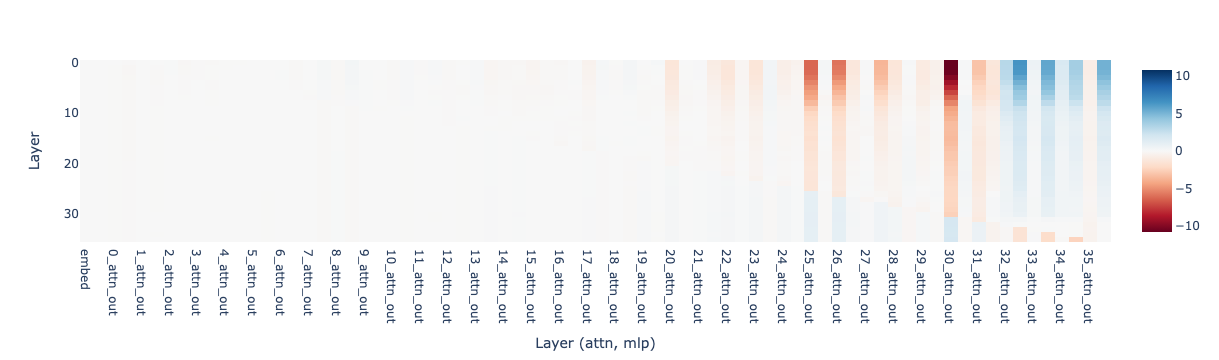

In [409]:
plot_ablate_idx_x_effect_idx_sum(total_direct_effect_target, target_direct_effect_ref, labels, key="")

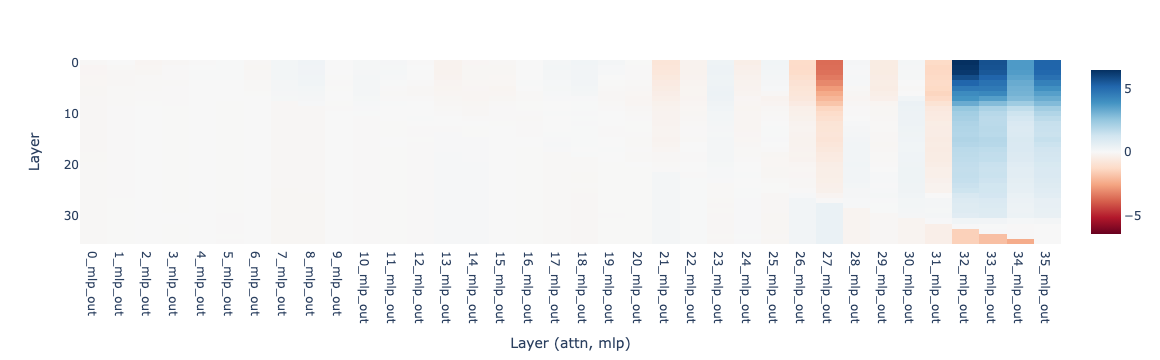

In [407]:
plot_ablate_idx_x_effect_idx_sum(total_direct_effect_target, target_direct_effect_ref, labels, key="mlp")

torch.Size([74])


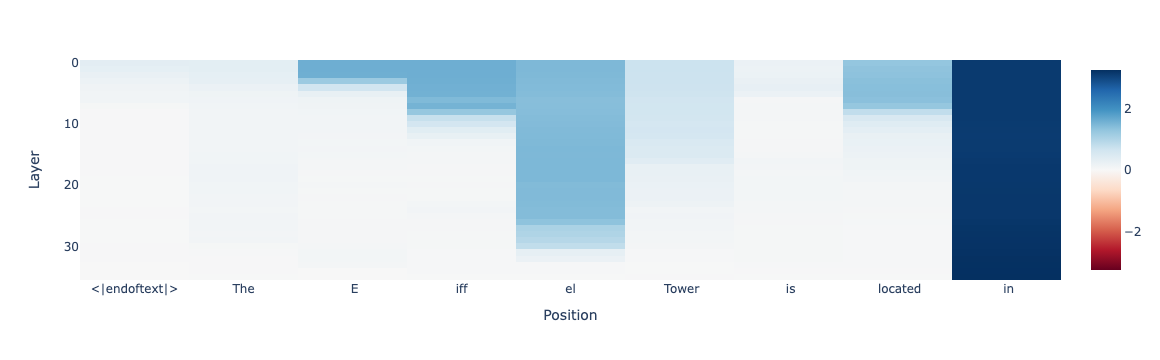

In [330]:
plot_largest_contributions_up_to(total_direct_effect_target, target_direct_effect_ref)

torch.Size([74])


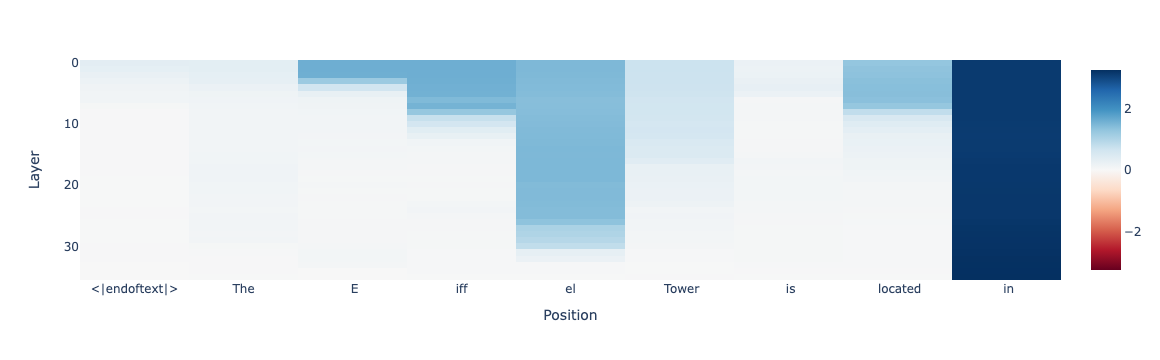

In [321]:
plot_largest_contributions_up_to(total_direct_effect_target, target_direct_effect_ref)

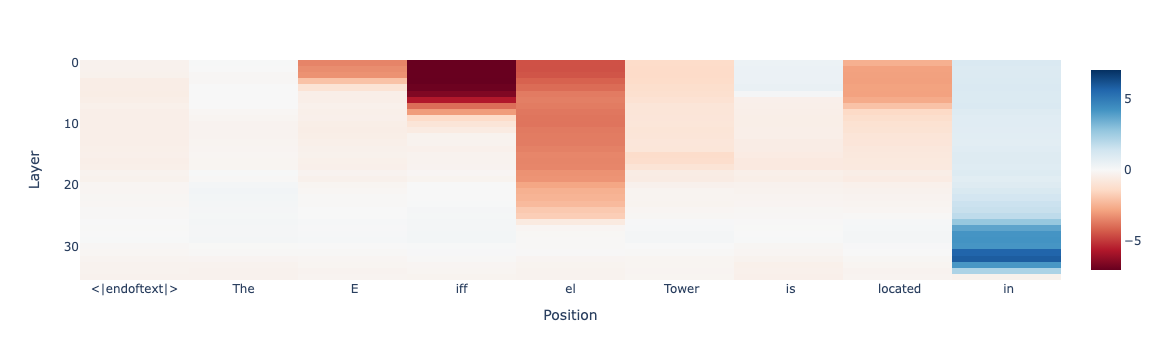

In [322]:
plot_sum_of_contributions_minus_ref(total_direct_effect_target, target_direct_effect_ref)

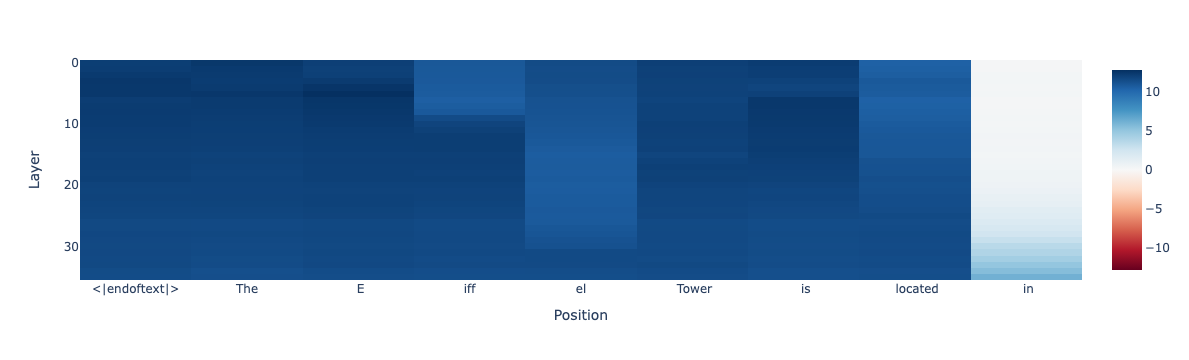

In [323]:
plot_sum_of_contributions_minus_ref(total_direct_effect_mle, mle_direct_effect_ref)

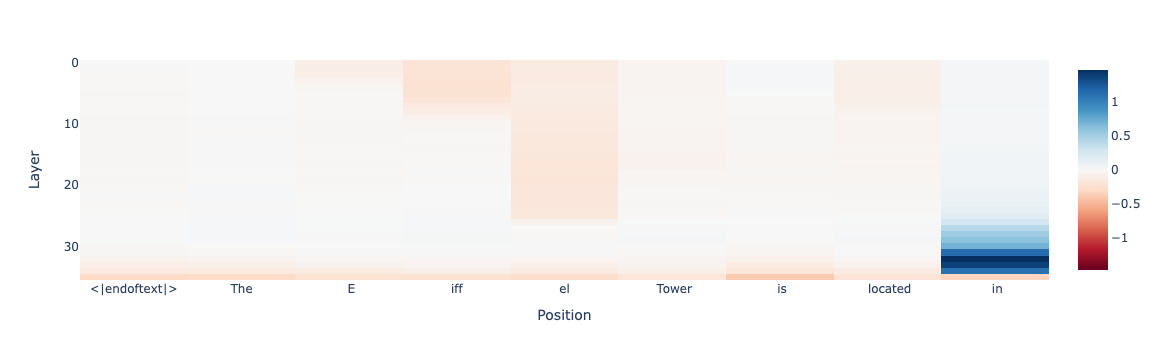

In [324]:
plot_sum_of_contributions_minus_ref_avg(total_direct_effect_target, target_direct_effect_ref)

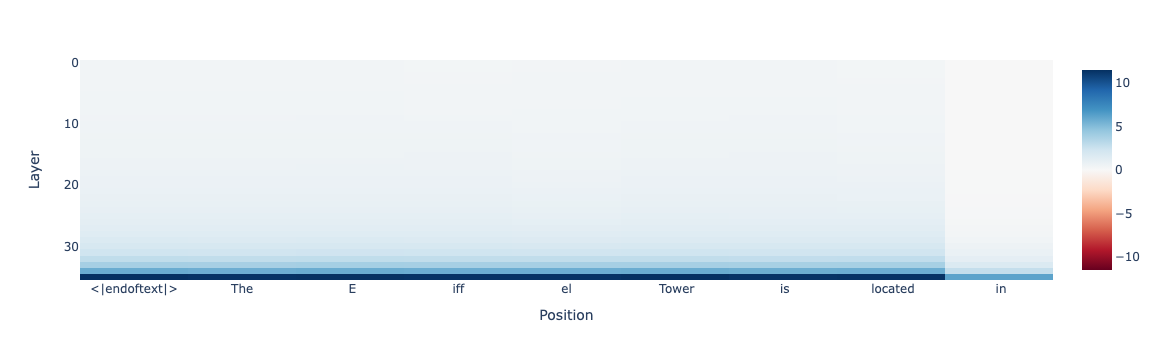

In [294]:
plot_sum_of_contributions_minus_ref_avg(total_direct_effect_mle, mle_direct_effect_ref)

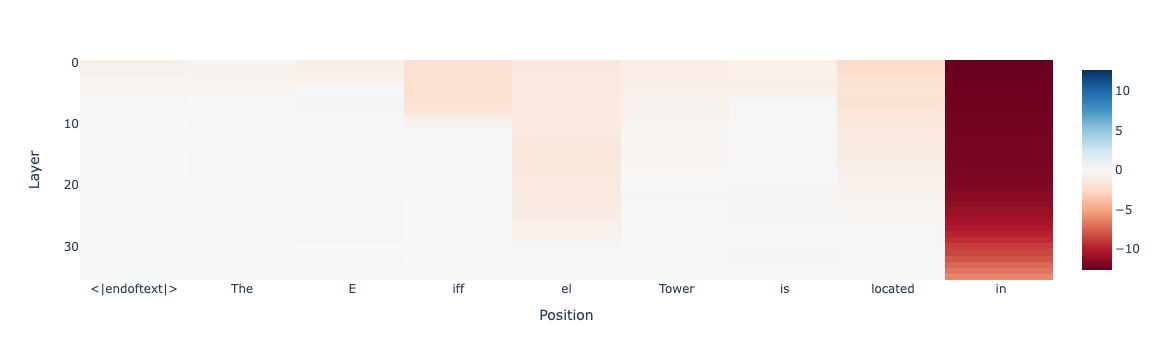

In [254]:
plot_sum_of_contributions(total_direct_effect_mle)

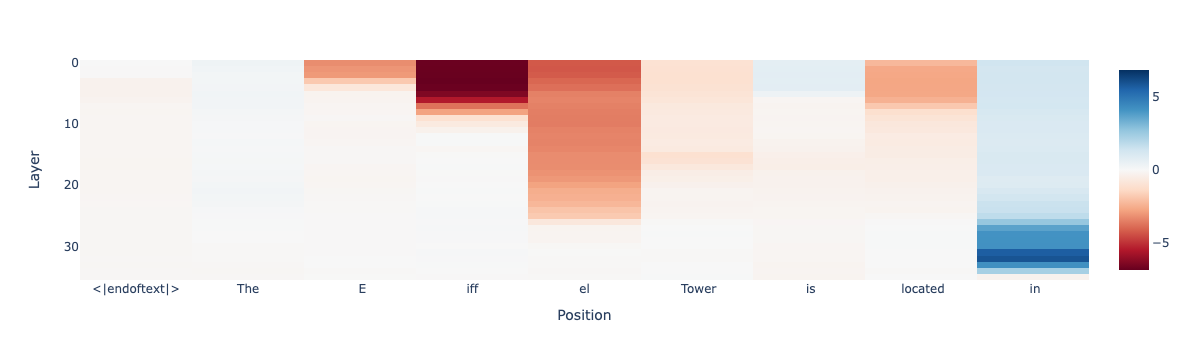

In [255]:
plot_sum_of_contributions(total_direct_effect_target)

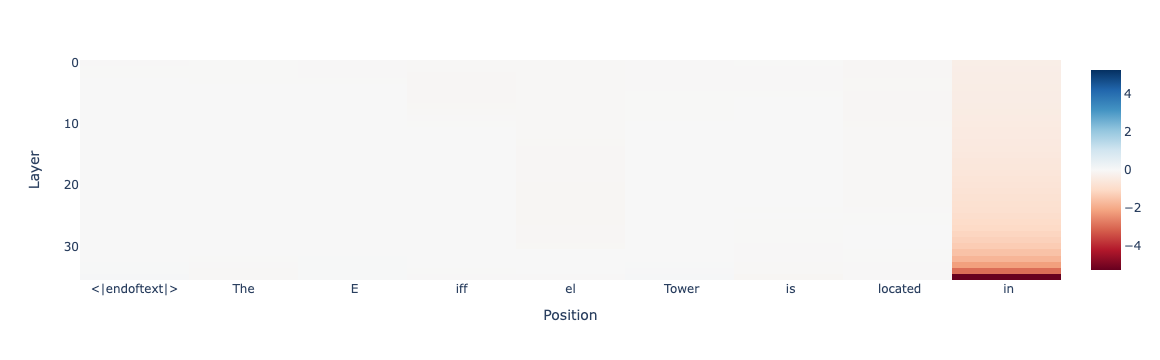

In [256]:
plot_sum_of_contributions_up_to(total_direct_effect_mle)

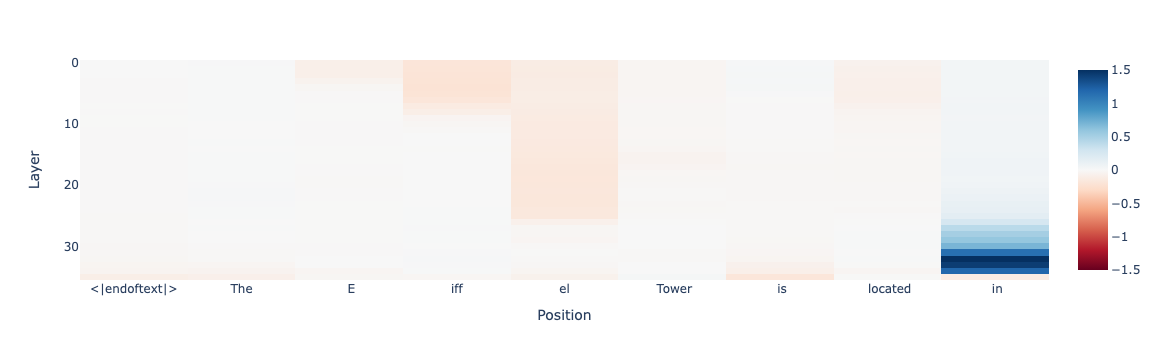

In [257]:
plot_sum_of_contributions_up_to(total_direct_effect_target)

## Total Effect (Delta Ablate)

In [20]:
def unembedding_function(residual_stack, cache, mlp=False) -> float:
    #we are only interested in applying the layer norm of the final layer on the final token
    #shape: [74, 5, 10, 1280] = n_layers, prompts, tokens, d_model
    z = cache.apply_ln_to_stack(residual_stack, layer = -1, mlp_input=mlp)
    z = z @ model.W_U
    print(z)
    return z

def patch_layer(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    cache):
    corrupted_residual_component[:, :, :] = cache[hook.name][:, :, :]
    """
    Restore a patch in clean run. 
    """
    return corrupted_residual_component
    
def total_effect(
             clean_prompt: str,
             corrupted_prompts: List[str],
             target: str, 
             corrupted_ablation=True, 
             activation_to_ablate = "attn_out", 
             mode="attn", 
             mlp_input=False):
    """
    activation_to_ablate: activation (resid_pre, attn_out, or mlp_out to ablate). resid_pre corresponds to the value of the residual
    stream at a layer and a position. attn_out and mlp_out correspond to the quantities added into the residual stream at a given 
    attention or mlp head. The values in the residual stream are preserved but the quantities being injected are corrupted. 
    
    mlp_input: Whether to include attn_out for the current
    layer - essentially decomposing the residual stream that's input to the MLP input rather than the Attn input.
    
    mode (str): Values are "all", "mlp" or "attn". "all" returns all
    components, "mlp" returns only the MLP components, and "attn" returns only the attention components.
    
    Delta_ablate_l
    """
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    #we take first token for the target. Not ideal though
    target_token_idx = model.to_tokens(target)[:,1] #remember to slice out the start pad token
        
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens which have multiple noise samples. 
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
    #The difference is states is attributed to the corrupted input. The difference in logit attributions
    #at each layer is the direct effect on that layer. 
    
    mle_token_idx = torch.argmax(clean_logits[:,-1,:], dim=-1).unsqueeze(-1)

    
    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        input_logits = clean_logits[:,-1,:]
        cache_to_restore = corrupted_cache
    else: 
        input_logits = corrupted_logits[:,-1,:]
        cache_to_restore = clean_cache
        
    #shape of input_logits: batch, tokens, vocab
    mle_centered_input_logits = input_logits.gather(index=mle_token_idx, dim=-1) - input_logits.mean(dim=-1, keepdim=True)
    target_centered_input_logits = input_logits.gather(index=target_token_idx, dim=-1) - input_logits.mean(dim=-1, keepdim=True)
    
    total_effect_mle = torch.zeros(model.cfg.n_layers, 
                                          device=device, dtype=torch.float32)
    total_effect_target = torch.zeros(model.cfg.n_layers,
                                             device=device, dtype=torch.float32)
    std_total_effect_mle = torch.zeros(model.cfg.n_layers, 
                                          device=device, dtype=torch.float32)
    std_total_effect_target = torch.zeros(model.cfg.n_layers,
                                             device=device, dtype=torch.float32)
    
    for layer in range(model.cfg.n_layers):
                        
        #here we run the prompt, add a hook point from the corrupted_cache to ablate 
        #a position and layer. We then run with cache to get a saved state of the activations. 
        hook_fn = partial(patch_layer, cache=corrupted_cache)            
        with model.hooks(
            fwd_hooks = [(utils.get_act_name(activation_to_ablate, layer),hook_fn)]
        ) as hooked_model:
            restored_logits, ablated_cache = hooked_model.run_with_cache(clean_tokens, return_type="logits")
            
        restored_logits = restored_logits[:,-1,:]
        mle_centered_restored_logits = restored_logits.gather(index=mle_token_idx, dim=-1) - restored_logits.mean(dim=-1, keepdim=True)
        target_centered_restored_logits = restored_logits.gather(index=target_token_idx, dim=-1) - restored_logits.mean(dim=-1, keepdim=True)
            
        effect_mle = (mle_centered_restored_logits - mle_centered_input_logits)
        effect_target = (target_centered_restored_logits - target_centered_input_logits)

        total_effect_mle[layer] = effect_mle.squeeze().mean()
        total_effect_target[layer] = effect_target.squeeze().mean()
        std_total_effect_mle[layer] = effect_mle.squeeze().std()
        std_total_effect_target[layer] = effect_target.squeeze().std()
        
    return {
        "total_effect_target" : total_effect_target.to("cpu"),
        "total_effect_mle" : total_effect_mle.to("cpu"),
        "std_total_effect_target" : std_total_effect_target.to("cpu"),
        "std_total_effect_mle" : std_total_effect_mle.to("cpu"),
    }


    

In [21]:
def run_experiment_on_total_effect(dataset, n, activation_to_ablate): 
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:n]
    
    results = []
    
    for idx in indices: 
        prompt, subject, target = sample_dataset(dataset, idx=idx)
        true_fact, corrupted_facts, target = resample_ablation(prompt, subject, target, n_noise_samples=10)
        result = total_effect(
            clean_prompt=true_fact, 
            corrupted_prompts=corrupted_facts, 
            target=target, 
            corrupted_ablation=True, 
            activation_to_ablate = activation_to_ablate,
            mode="all",
            mlp_input=False,
        )
        results.append(result)
    return results

results_attn = run_experiment_on_total_effect(dataset, n=5, activation_to_ablate="attn_out") 
# results_mlp = run_experiment_on_delta_ablate(dataset, n=10, activation_to_ablate="mlp_out") 
# results_resid = run_experiment_on_delta_ablate(dataset, n=10, activation_to_ablate="attn_out") 

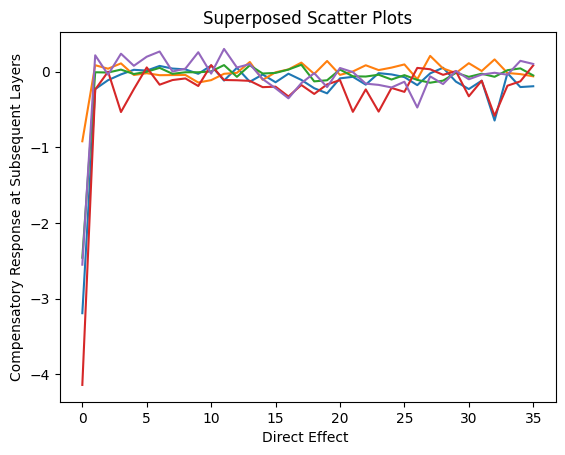

In [29]:
def plot_total_effect(results, attribution_type="attn", use_target=True):
    
    all_means = []
    all_stds = []
    for result in results: 
        if use_target: 
            mean_total_effect = result["total_effect_target"]
            std_total_effect = result["std_total_effect_target"]
        else: 
            mean_total_effect = result["total_effect_target"]
            std_total_effect = result["std_total_effect_target"]
        all_means.append(mean_total_effect)
        all_stds.append(std_total_effect)
        
    all_means = torch.stack(all_means)
    all_stds = torch.stack(all_stds)
    
    fig, ax = plt.subplots()  
    for experiment_idx in range(len(results)): 
        y = all_means[experiment_idx]
        plt.plot(y)
        
        ax.set_xlabel('Direct Effect ')
        ax.set_ylabel('Compensatory Response at Subsequent Layers')
        ax.set_title('Superposed Scatter Plots')
    
    
plot_total_effect(results_attn, attribution_type="attn", use_target=True) 


In [24]:
results_attn[0]["total_effect_target"]

tensor([-3.1926, -0.2290, -0.1110, -0.0348,  0.0257,  0.0156,  0.0770,  0.0423,
         0.0310, -0.0272,  0.0815, -0.1166,  0.0523, -0.1320, -0.0364, -0.1388,
        -0.0259, -0.1080, -0.2179, -0.2854, -0.0874, -0.0670, -0.1704, -0.0186,
        -0.0352, -0.0708, -0.1770, -0.0214,  0.0531, -0.1310, -0.2287, -0.1183,
        -0.6449, -0.0185, -0.2025, -0.1916])

## Ablating an entire layer (Reproducing Hydra)

In [253]:
def unembedding_function(residual_stack, cache, mlp=False) -> float:
    #we are only interested in applying the layer norm of the final layer on the final token
    #shape: [74, 5, 10, 1280] = n_layers, prompts, tokens, d_model
    z = cache.apply_ln_to_stack(residual_stack, layer = -1, mlp_input=mlp)
    z = z @ model.W_U
    print(z)
    return z

def direct_effect(clean_cache,
                  corrupted_cache,
                  mle_token_idx,
                  target_token_idx, 
                  mode, 
                  mlp_input, 
                  return_labels=False,
                  return_all=False): 
    """
    Decomposes the residual stream input to layer L into a stack of the output of previous layers. 
    The sum of these is the input to layer L (plus embedding and pos embedding). 
    This is useful for attributing model behaviour to different components of the residual stream
    
    Clean cache: all states when running clean_prompt
    Corrupted_cache: all states when running corrupted_prompt
    """
    if return_labels: 
        residual_clean_stack, labels = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=True)
    else: 
        residual_clean_stack = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
        
    residual_corrupted_stack = corrupted_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
    
    #shape: [74, 4, 9, 50257] = n_layers, batch, tokens, vocab_size
    residual_clean_logits = unembedding_function(residual_clean_stack, clean_cache)
    residual_clean_logits = residual_clean_logits[:,:,-1,:]
    
    residual_corrupted_logits = unembedding_function(residual_corrupted_stack, corrupted_cache)
    residual_corrupted_logits = residual_corrupted_logits[:,:,-1,:] #get for final token only
    
    target_idx_expanded = target_token_idx.repeat(residual_clean_logits.shape[0],1,1)
    mle_idx_expanded = mle_token_idx.repeat(residual_clean_logits.shape[0],1,1)
    
    #center the logits with mean
    u_residual_corrupted_logits = residual_corrupted_logits.mean(dim=-1).unsqueeze(dim=-1)
    u_residual_clean_logits = residual_clean_logits.mean(dim=-1).unsqueeze(dim=-1)

    target_residual_corrupted_logit = residual_corrupted_logits.gather(index=target_idx_expanded, dim=-1) - u_residual_corrupted_logits
    mle_residual_corrupted_logit = residual_corrupted_logits.gather(index=mle_idx_expanded, dim=-1) - u_residual_corrupted_logits
    target_residual_clean_logit = residual_clean_logits.gather(index=target_idx_expanded, dim=-1) - u_residual_clean_logits
    mle_residual_clean_logit = residual_clean_logits.gather(index=mle_idx_expanded, dim=-1) - u_residual_clean_logits
    
    target_direct_effect = target_residual_corrupted_logit - target_residual_clean_logit
    mle_direct_effect = mle_residual_corrupted_logit - mle_residual_clean_logit #shape: layers, batch, target_tokens (1)
    
    if return_all: 
        return (labels,
                target_residual_corrupted_logit.to("cpu"),
                mle_residual_corrupted_logit.to("cpu"),
                target_residual_clean_logit.to("cpu"),
                mle_residual_clean_logit.to("cpu"))
    
    if return_labels: 
        return labels, mle_direct_effect, target_direct_effect
    
    #shapes: layers, batch, 1 = direct effect at each layer due to the ablation
    return mle_direct_effect, target_direct_effect

def patch_layer(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    cache):
    corrupted_residual_component[:, :, :] = cache[hook.name][:, :, :]
    """
    Restore a patch in clean run. 
    """
    return corrupted_residual_component
    
def compensatory_effect(
                         clean_prompt: str,
                         corrupted_prompts: List[str],
                         target: str, 
                         corrupted_ablation=True, 
                         activation_to_ablate = "attn_out", 
                         mode="attn", 
                         mlp_input=False, 
                         early_exit_1=False):
    """
    activation_to_ablate: activation (resid_pre, attn_out, or mlp_out to ablate). resid_pre corresponds to the value of the residual
    stream at a layer and a position. attn_out and mlp_out correspond to the quantities added into the residual stream at a given 
    attention or mlp head. The values in the residual stream are preserved but the quantities being injected are corrupted. 
    
    mlp_input: Whether to include attn_out for the current
    layer - essentially decomposing the residual stream that's input to the MLP input rather than the Attn input.
    
    mode (str): Values are "all", "mlp" or "attn". "all" returns all
    components, "mlp" returns only the MLP components, and "attn" returns only the attention components.
    
    Here we get the compensatory effect of downstream layers following an ablation on the MLE token logits and the target token logits.
    """
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    #we take first token for the target. Not ideal though
    target_token_idx = model.to_tokens(target)[:,1] #remember to slice out the start pad token
        
    
    
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens which have multiple noise samples. 
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    
    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
    #The difference is states is attributed to the corrupted input. The difference in logit attributions
    #at each layer is the direct effect on that layer. 
    
    #if we want to inverse the corruption: set corrupted_ablation to False. This runs the corrupted prompts
    #and tracks the effect of restore clean states. For sake of clean code, we simply swap variables. 
    if not corrupted_ablation: 
        temp_cache = corrupted_cache
        temp_logits = corrupted_logits
        corrupted_cache = clean_cache
        corrupted_logits = clean_logits
        clean_cache = temp_cache
        clean_logits = temp_logits
    
    mle_token_idx = torch.argmax(clean_logits[:,-1,:], dim=-1).unsqueeze(-1)
    # layers, batch, 1 = direct effect at each layer due to the ablation
    layer_names, mle_direct_effect, target_direct_effect = direct_effect(clean_cache,
                                                            corrupted_cache,
                                                            mle_token_idx,
                                                            target_token_idx,
                                                            mode=mode,
                                                            mlp_input=mlp_input, 
                                                           return_labels=True)
    if early_exit_1: 
        x = direct_effect(clean_cache,
                        corrupted_cache,
                        mle_token_idx,
                        target_token_idx,
                        mode=mode,
                        mlp_input=mlp_input, 
                        return_all=True,
                        return_labels=True)
        return x
    
    #average over batch
    mle_direct_effect = mle_direct_effect.squeeze().mean(dim=-1)
    target_direct_effect = target_direct_effect.squeeze().mean(dim=-1)
    
    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        #shape: noise_batch, n_tokens, vocab_size
        final_token_logits = clean_logits
    else: 
        final_token_logits = corrupted_logits
        
    
    total_direct_effect_mle = torch.zeros(model.cfg.n_layers, 
                                          target_direct_effect.shape[0], 
                                          device=device, dtype=torch.float32)
    total_direct_effect_target = torch.zeros(model.cfg.n_layers,
                                             target_direct_effect.shape[0], 
                                             device=device, dtype=torch.float32)
    
    for layer in range(model.cfg.n_layers):
                        
        #here we run the prompt, add a hook point from the corrupted_cache to ablate 
        #a position and layer. We then run with cache to get a saved state of the activations. 
        hook_fn = partial(patch_layer, cache=corrupted_cache)            
        with model.hooks(
            fwd_hooks = [(utils.get_act_name(activation_to_ablate, layer),hook_fn)]
        ) as hooked_model:
            restored_logits, ablated_cache = hooked_model.run_with_cache(clean_tokens, return_type="logits")

        # layers, batch, 1 = direct effect at each layer due to the ablation
        mle_direct_effect_ablated, target_direct_effect_ablated = direct_effect(clean_cache,
                                                                                ablated_cache,
                                                                                mle_token_idx,
                                                                                target_token_idx,
                                                                                mode=mode,
                                                                                mlp_input=mlp_input)
        total_direct_effect_mle[layer] = mle_direct_effect_ablated.squeeze().mean(dim=-1)
        total_direct_effect_target[layer] = target_direct_effect_ablated.squeeze().mean(dim=-1)


    return {
        "layer_names" : layer_names,
        "ablate_direct_effect_on_mle" : total_direct_effect_mle.to("cpu"),
        "ablate_direct_effect_on_target" : total_direct_effect_target.to("cpu"),
        "direct_effect_mle" : mle_direct_effect.to("cpu"),
        "direct_effect_target" : target_direct_effect.to("cpu")
    }
    

In [25]:
def run_experiment_on_delta_ablate(dataset, n, activation_to_ablate): 
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:n]
    
    results = []
    
    for idx in indices: 
        prompt, subject, target = sample_dataset(dataset, idx=idx)
        true_fact, corrupted_facts, target = resample_ablation(prompt, subject, target, n_noise_samples=10)
        print(true_fact)
        result = compensatory_effect(
            clean_prompt=true_fact, 
            corrupted_prompts=corrupted_facts, 
            target=target, 
            corrupted_ablation=True, 
            activation_to_ablate = activation_to_ablate,
            mode="all",
            mlp_input=False,
        )
        results.append(result)
    return results

results_attn = run_experiment_on_delta_ablate(dataset, n=20, activation_to_ablate="attn_out") 
# results_mlp = run_experiment_on_delta_ablate(dataset, n=10, activation_to_ablate="mlp_out") 
# results_resid = run_experiment_on_delta_ablate(dataset, n=10, activation_to_ablate="attn_out") 

Johan Jongkind speaks the language


NameError: name 'compensatory_effect' is not defined

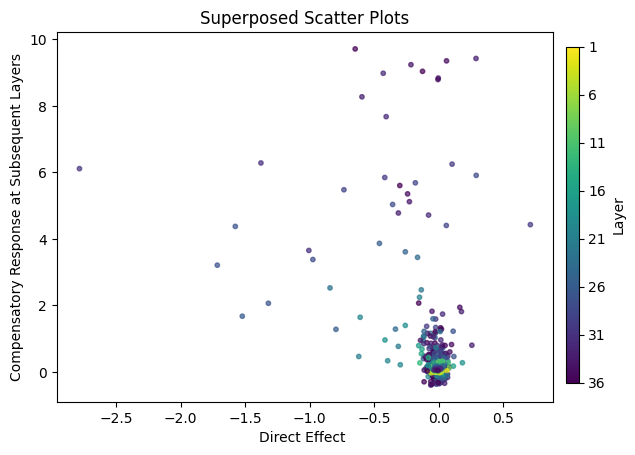

In [250]:
def plot_delta_ablate_by_delta_unembed(results, attribution_type="attn", use_target=True):
    # labels, target_residual_clean_logit, mle_residual_corrupted_logit, target_residual_clean_logit, mle_residual_clean_logit
    layer_names = results[0]["layer_names"]
    idx_of_interest = torch.tensor([attribution_type in l in l for l in layer_names])
    attn_idx = torch.tensor(["attn" in l in l for l in layer_names])
    
    n_ablations = results[0]["ablate_direct_effect_on_target"].shape[0]
    
    all_compensatory_effect = torch.zeros((len(results), n_ablations))
    all_ablate_direct_effect = torch.zeros((len(results), n_ablations))
    
    for i,result in enumerate(results):
        ablate_direct_effect_on_mle = result["ablate_direct_effect_on_mle"]
        ablate_direct_effect_on_target = result["ablate_direct_effect_on_target"]
        direct_effect_mle = result["direct_effect_mle"]
        direct_effect_target = result["direct_effect_target"]
        
        if use_target: 
            ablate_direct_effect_all_layers = ablate_direct_effect_on_target
            unembed_direct_effect_all_layers = direct_effect_target
        else: 
            ablate_direct_effect_all_layers = ablate_direct_effect_on_mle
            unembed_direct_effect_all_layers = direct_effect_mle
        
        #this is the direct effect on logits given ablation to attention_out. We index points of interest (future attention and/or mlp outs)
        ablate_direct_effect = ablate_direct_effect_all_layers[:,idx_of_interest]
        #direct effect on logits due to corruption. Same indexing
        unembed_direct_effect = unembed_direct_effect_all_layers[idx_of_interest]
        
        #calculate compensatory response
        compensatory_response = torch.zeros(n_ablations)
        direct_effect_on_ablated_layer = torch.zeros(n_ablations)
        
        for idx in range(n_ablations): 
            ablate_direct_effect_all_layers = ablate_direct_effect[idx]
            compensatory_response[idx] = (ablate_direct_effect_all_layers[:idx] - unembed_direct_effect[:idx]).sum()
            direct_effect_on_ablated_layer[idx] = ablate_direct_effect[idx,idx]
            
            
        all_compensatory_effect[i] = compensatory_response
        all_ablate_direct_effect[i] = direct_effect_on_ablated_layer
    
    fig, ax = plt.subplots()  
    for experiment_idx in range(len(results)): 
        y = all_compensatory_effect[experiment_idx]
        x = all_ablate_direct_effect[experiment_idx]
        layer_colors = plt.cm.viridis(np.linspace(0, 1, y.shape[-1]))[::-1]
        ax.scatter(y = y,
                   x = x,
                   c=layer_colors, 
                    s=10, 
                    marker='o', 
                    alpha=0.7
                )
        
        ax.set_xlabel('Direct Effect ')
        ax.set_ylabel('Compensatory Response at Subsequent Layers')
        ax.set_title('Superposed Scatter Plots')
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position and size of the colorbar
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), cax=cax)
    tick_locations = np.linspace(0, 1, 8)  # Adjust the number of ticks as needed
    tick_labels = np.arange(36, 0, -5)
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Layer')


plot_delta_ablate_by_delta_unembed(results_attn, attribution_type="attn", use_target=False)
        
    

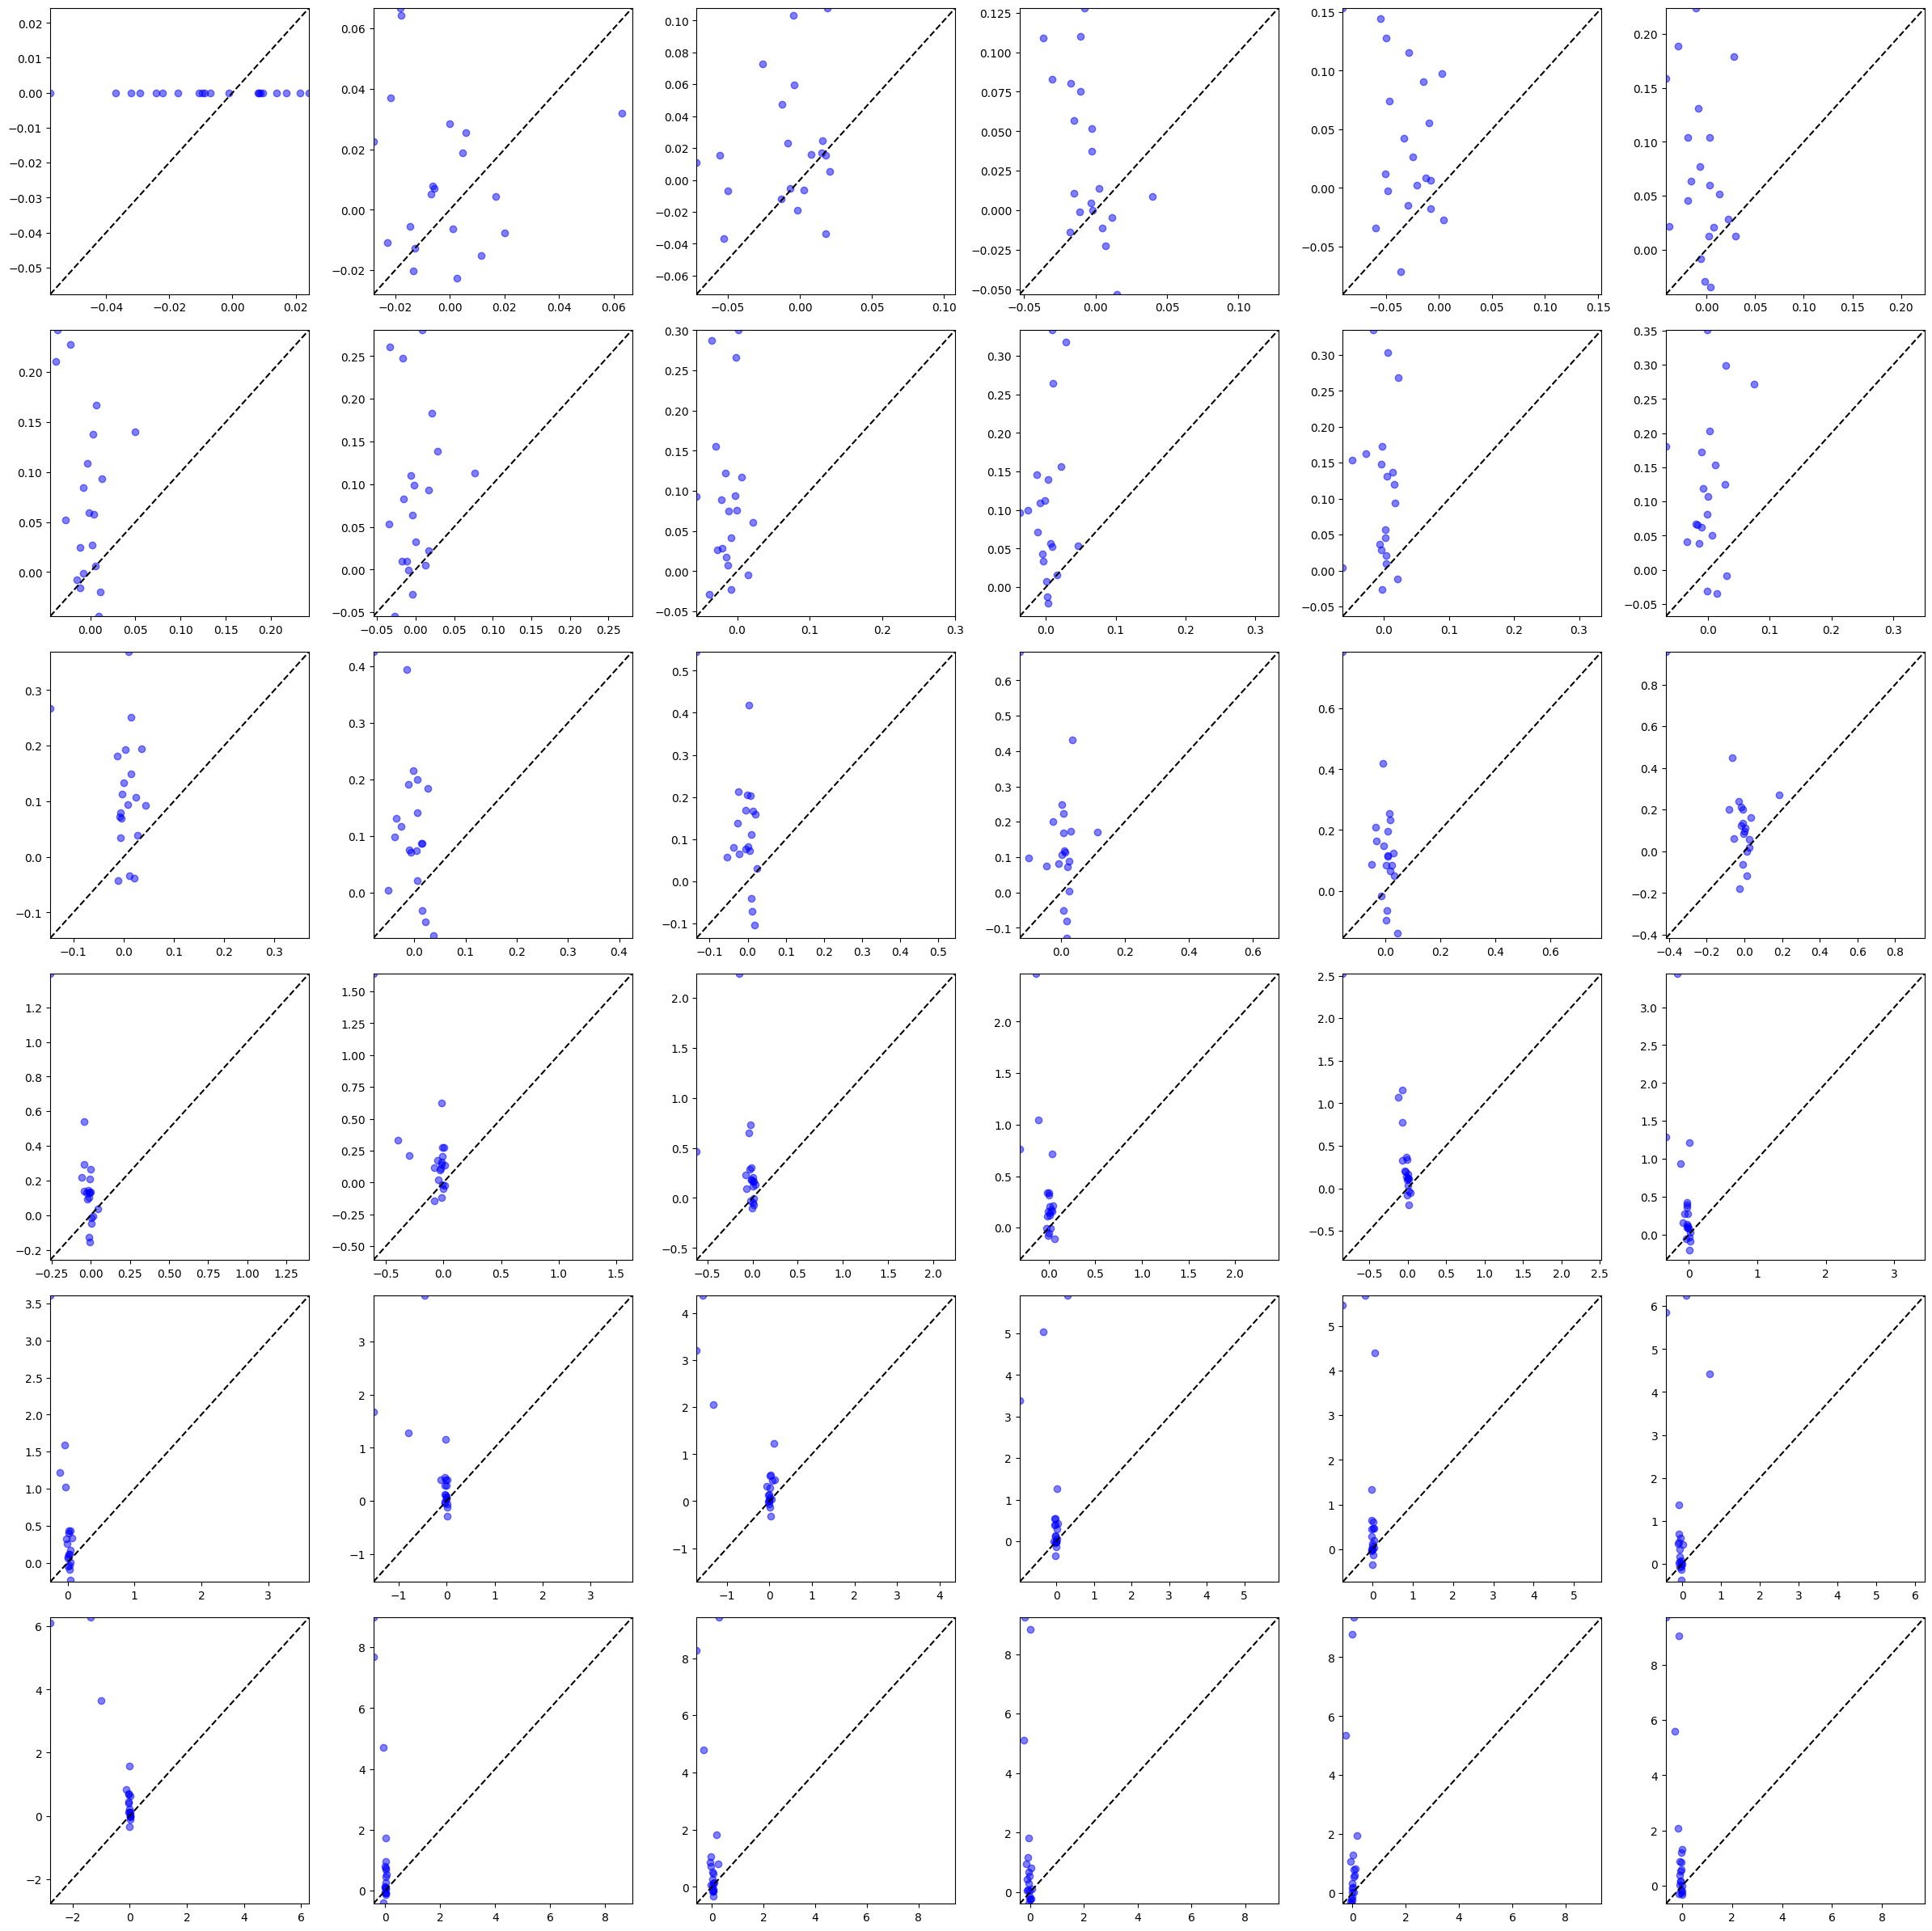

In [252]:
def plot_compensatory_by_layer(results, attribution_type="attn", use_target=True):
    # labels, target_residual_clean_logit, mle_residual_corrupted_logit, target_residual_clean_logit, mle_residual_clean_logit
    layer_names = results[0]["layer_names"]
    idx_of_interest = torch.tensor([attribution_type in l in l for l in layer_names])
    attn_idx = torch.tensor(["attn" in l in l for l in layer_names])
    
    n_ablations = results[0]["ablate_direct_effect_on_target"].shape[0]
    
    all_compensatory_effect = torch.zeros((len(results), n_ablations))
    all_ablate_direct_effect = torch.zeros((len(results), n_ablations))
    
    for i,result in enumerate(results):
        ablate_direct_effect_on_mle = result["ablate_direct_effect_on_mle"]
        ablate_direct_effect_on_target = result["ablate_direct_effect_on_target"]
        direct_effect_mle = result["direct_effect_mle"]
        direct_effect_target = result["direct_effect_target"]
        
        if use_target: 
            ablate_direct_effect_all_layers = ablate_direct_effect_on_target
            unembed_direct_effect_all_layers = direct_effect_target
        else: 
            ablate_direct_effect_all_layers = ablate_direct_effect_on_mle
            unembed_direct_effect_all_layers = direct_effect_mle
        
        #this is the direct effect on logits given ablation to attention_out. We index points of interest (future attention and/or mlp outs)
        ablate_direct_effect = ablate_direct_effect_all_layers[:,idx_of_interest]
        #direct effect on logits due to corruption. Same indexing
        unembed_direct_effect = unembed_direct_effect_all_layers[idx_of_interest]
        
        #calculate compensatory response
        compensatory_response = torch.zeros(n_ablations)
        direct_effect_on_ablated_layer = torch.zeros(n_ablations)
        
        for idx in range(n_ablations): 
            ablate_direct_effect_all_layers = ablate_direct_effect[idx]
            compensatory_response[idx] = (ablate_direct_effect_all_layers[:idx] - unembed_direct_effect[:idx]).sum()
            direct_effect_on_ablated_layer[idx] = ablate_direct_effect[idx,idx]
            
            
        all_compensatory_effect[i] = compensatory_response
        all_ablate_direct_effect[i] = direct_effect_on_ablated_layer
    
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 24))

    for i, ax in enumerate(axes.flat):
        y = all_compensatory_effect[:,i]
        x = all_ablate_direct_effect[:,i]
        
        ax.scatter(x, y, label=f'Layer {i}', color='blue', alpha=0.5)
        # Set x and y limits based on the minimum and maximum values of the plotted data
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

        # Set the limits for the dashed line to go through zero and extend on both sides
        line_min = min(min_val, 0)
        line_max = max(max_val, 0)
        ax.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='dashed')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_compensatory_by_layer(results_attn, attribution_type="attn", use_target=False)
        
    

In [224]:
def unembedding_function(residual_stack, cache, mlp=False) -> float:
    #we are only interested in applying the layer norm of the final layer on the final token
    #shape: [74, 5, 10, 1280] = n_layers, prompts, tokens, d_model
    z = cache.apply_ln_to_stack(residual_stack, layer = -1, mlp_input=mlp)
    z = z @ model.W_U
    return z

def direct_effect(clean_cache,
                  corrupted_cache,
                  mle_token_idx,
                  target_token_idx, 
                  mode, 
                  mlp_input, 
                  return_labels=False): 
    """
    Decomposes the residual stream input to layer L into a stack of the output of previous layers. 
    The sum of these is the input to layer L (plus embedding and pos embedding). 
    This is useful for attributing model behaviour to different components of the residual stream
    
    Clean cache: all states when running clean_prompt
    Corrupted_cache: all states when running corrupted_prompt
    """
    if return_labels: 
        residual_clean_stack, labels = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=True)
    else: 
        residual_clean_stack = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
        
    residual_corrupted_stack = corrupted_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
    
    #shape: [74, 4, 9, 50257] = n_layers, batch, tokens, vocab_size
    residual_clean_logits = unembedding_function(residual_clean_stack, clean_cache)
    residual_clean_logits = residual_clean_logits[:,:,-1,:]
    
    residual_corrupted_logits = unembedding_function(residual_corrupted_stack, corrupted_cache)
    residual_corrupted_logits = residual_corrupted_logits[:,:,-1,:] #get for final token only
    
    target_idx_expanded = target_token_idx.repeat(residual_clean_logits.shape[0],1,1)
    mle_idx_expanded = mle_token_idx.repeat(residual_clean_logits.shape[0],1,1)
    
    target_residual_corrupted_logit = residual_corrupted_logits.gather(index=target_idx_expanded, dim=-1)
    mle_residual_corrupted_logit = residual_corrupted_logits.gather(index=mle_idx_expanded, dim=-1)
    target_residual_clean_logit = residual_clean_logits.gather(index=target_idx_expanded, dim=-1)
    mle_residual_clean_logit = residual_clean_logits.gather(index=mle_idx_expanded, dim=-1)
    
    target_direct_effect = target_residual_corrupted_logit - target_residual_clean_logit
    mle_direct_effect = mle_residual_corrupted_logit - mle_residual_clean_logit #shape: 1, batch, target_tokens (1)
    
    if return_labels: 
        return labels, mle_direct_effect, target_direct_effect
    
    #shapes: layers, batch, 1 = direct effect at each layer due to the ablation
    return mle_direct_effect, target_direct_effect

def patch_layer(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    cache):
    corrupted_residual_component[:, :, :] = cache[hook.name][:, :, :]
    """
    Restore a patch in clean run. 
    """
    return corrupted_residual_component
    
def compensatory_effect(
                         clean_prompt: str,
                         corrupted_prompts: List[str],
                         target: str, 
                         corrupted_ablation=True, 
                         activation_to_ablate = "attn_out", 
                         mode="attn", 
                         mlp_input=False):
    """
    activation_to_ablate: activation (resid_pre, attn_out, or mlp_out to ablate). resid_pre corresponds to the value of the residual
    stream at a layer and a position. attn_out and mlp_out correspond to the quantities added into the residual stream at a given 
    attention or mlp head. The values in the residual stream are preserved but the quantities being injected are corrupted. 
    
    mlp_input: Whether to include attn_out for the current
    layer - essentially decomposing the residual stream that's input to the MLP input rather than the Attn input.
    
    mode (str): Values are "all", "mlp" or "attn". "all" returns all
    components, "mlp" returns only the MLP components, and "attn" returns only the attention components.
    
    Here we get the compensatory effect of downstream layers following an ablation on the MLE token logits and the target token logits.
    """
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    #we take first token for the target. Not ideal though
    target_token_idx = model.to_tokens(target)[:,1] #remember to slice out the start pad token
        
    
    
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens which have multiple noise samples. 
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    
    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
    #The difference is states is attributed to the corrupted input. The difference in logit attributions
    #at each layer is the direct effect on that layer. 
    
    #if we want to inverse the corruption: set corrupted_ablation to False. This runs the corrupted prompts
    #and tracks the effect of restore clean states. For sake of clean code, we simply swap variables. 
    if not corrupted_ablation: 
        temp_cache = corrupted_cache
        temp_logits = corrupted_logits
        corrupted_cache = clean_cache
        corrupted_logits = clean_logits
        clean_cache = temp_cache
        clean_logits = temp_logits
    
    mle_token_idx = torch.argmax(clean_logits[:,-1,:], dim=-1).unsqueeze(-1)
    # layers, batch, 1 = direct effect at each layer due to the ablation
    layer_names, mle_direct_effect, target_direct_effect = direct_effect(clean_cache,
                                                            corrupted_cache,
                                                            mle_token_idx,
                                                            target_token_idx,
                                                            mode=mode,
                                                            mlp_input=mlp_input, 
                                                            return_labels=True)
    #average over batch
    mle_direct_effect = mle_direct_effect.squeeze().mean(dim=-1)
    target_direct_effect = target_direct_effect.squeeze().mean(dim=-1)
    
    attn_idx = torch.tensor(["attn" in l for l in x]).float().to(device).unsqueeze(-1).unsqueeze(-1)
    mlp_idx = torch.tensor(["mlp" in l for l in x]).float().to(device).unsqueeze(-1).unsqueeze(-1)

    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        #shape: noise_batch, n_tokens, vocab_size
        final_token_logits = clean_logits
    else: 
        final_token_logits = corrupted_logits
        
    
    total_direct_effect_mle = torch.zeros(model.cfg.n_layers, 
                                          target_direct_effect.shape[0], 
                                          device=device, dtype=torch.float32)
    total_direct_effect_target = torch.zeros(model.cfg.n_layers,
                                             target_direct_effect.shape[0], 
                                             device=device, dtype=torch.float32)
    
    for layer in range(model.cfg.n_layers):
                        
        #here we run the prompt, add a hook point from the corrupted_cache to ablate 
        #a position and layer. We then run with cache to get a saved state of the activations. 
        hook_fn = partial(patch_layer, cache=corrupted_cache)            
        with model.hooks(
            fwd_hooks = [(utils.get_act_name(activation_to_ablate, layer),hook_fn)]
        ) as hooked_model:
            restored_logits, ablated_cache = hooked_model.run_with_cache(clean_tokens, return_type="logits")

        # layers, batch, 1 = direct effect at each layer due to the ablation
        mle_direct_effect_ablated, target_direct_effect_ablated = direct_effect(clean_cache,
                                                                                ablated_cache,
                                                                                mle_token_idx,
                                                                                target_token_idx,
                                                                                mode=mode,
                                                                                mlp_input=mlp_input)

        total_direct_effect_mle[layer] = mle_direct_effect_ablated.squeeze().mean(dim=-1)
        total_direct_effect_target[layer] = target_direct_effect_ablated.squeeze().mean(dim=-1)


    return {
        "layer_names" : layer_names,
        "ablate_direct_effect_on_mle" : total_direct_effect_mle.to("cpu"),
        "ablate_direct_effect_on_target" : total_direct_effect_target.to("cpu"),
        "direct_effect_mle" : mle_direct_effect.to("cpu"),
        "direct_effect_target" : target_direct_effect.to("cpu")
    }
    

In [226]:
def run_experiment(dataset, n): 
    
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:n]
    
    results = []
    
    for idx in indices: 
        prompt, subject, target = sample_dataset(dataset, idx=idx)
        print(prompt.format(subject), target)
        true_fact, corrupted_facts, target = resample_ablation(prompt, subject, target, n_noise_samples=3)
        retval = compensatory_effect(
            clean_prompt=true_fact, 
            corrupted_prompts=corrupted_facts, 
            target=target, 
            corrupted_ablation=True, 
            activation_to_ablate = "attn_out",
            mode="all",
            mlp_input=False
        )
        results.append(retval)
    return results

results = run_experiment(dataset, n=20)

Mike Cowlishaw is employed by IBM
Sturla Gunnarsson, who has a citizenship from Canada
United Services Recreation Ground is in Portsmouth
Joe Belfiore works for Microsoft
Victoria Inner Harbour Airport is named for Victoria
Delta Works, in Netherlands
Ace Kefford originated from Birmingham
The official language of France is French
Twenty Good Years premiered on NBC
David Kershenbaum originated from Springfield
Fort Humboldt State Historic Park is located in California
Renault Estafette is created by Renault
Echo Arena Liverpool can be found in Liverpool
Paolo Martin has a citizenship from Italy
Buck Martinez, who plays the position catcher
Diego Fuser plays in the position of midfielder
The law in North Dakota declares the language English
Possession Islands, in Antarctica
National Football Federation of Guatemala belongs to the organization of FIFA
Vladimír Růžička, the hockey


In [229]:
def plot_compensatory_response_vs_direct_effect(results, target_logit=True, contribution="all"):
    layer_names = results[0]["layer_names"]
    n_ablations = results[0]["ablate_direct_effect_on_target"].shape[0]
    attn_idx = torch.tensor(["attn" in l for l in layer_names]).float()
    mlp_idx = torch.tensor(["mlp" in l for l in layer_names]).float()
    
    plot_data_y = torch.zeros((len(results), n_ablations, len(layer_names)))
    plot_data_x = torch.zeros((len(results), n_ablations, len(layer_names)))
                              
    for i,sample in enumerate(results): 
        if target_logit: 
            ablate_direct_effect = sample["ablate_direct_effect_on_target"]
            direct_effect = sample["direct_effect_target"]
        else: 
            #shape: n_attentions x (n_attentions + n_mlps)
            ablate_direct_effect = sample["ablate_direct_effect_on_mle"]
            #shape (n_attentions + n_mlps)
            direct_effect = sample["direct_effect_mle"]
        
        compensatory_effect = torch.zeros((n_ablations, len(layer_names)))
        for ablate_idx in range(n_ablations):
            for layer_idx in range(len(layer_names)): 
                ce = ablate_direct_effect[ablate_idx, ablate_idx:].sum()
                ce = ce - direct_effect[ablate_idx:].sum()
                compensatory_effect[ablate_idx, layer_idx] = ce
            
        
        plot_data_y[i] = compensatory_effect
        plot_data_x[i] = direct_effect
        
    plot_data_y = plot_data_y.permute(1,0,2)
    plot_data_x = plot_data_x.permute(1,0,2)


    # Create a 6x6 grid of subplots
    fig, axes = plt.subplots(6, 6, figsize=(15, 12))

    # Loop through each subplot and customize
    k = 0
    for i in range(6):
        for j in range(6):
            ax = axes[i, j]
            
            data_y = plot_data_y[k].flatten()
            data_x = plot_data_x[k].flatten()
            
            
            x_min, x_max = data_x.min(), data_x.max()
            y_min, y_max = data_y.min(), data_y.max()
            
            ax.scatter(data_x, data_y, marker='o', alpha=0.5)
            ax.set_title(f'Ablation {k}')
            ax.set_xticks(np.linspace(x_min, x_max, num=3))
            ax.set_yticks(np.linspace(y_min, y_max, num=5))
            k+=1

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()        
        
    
        
     
    

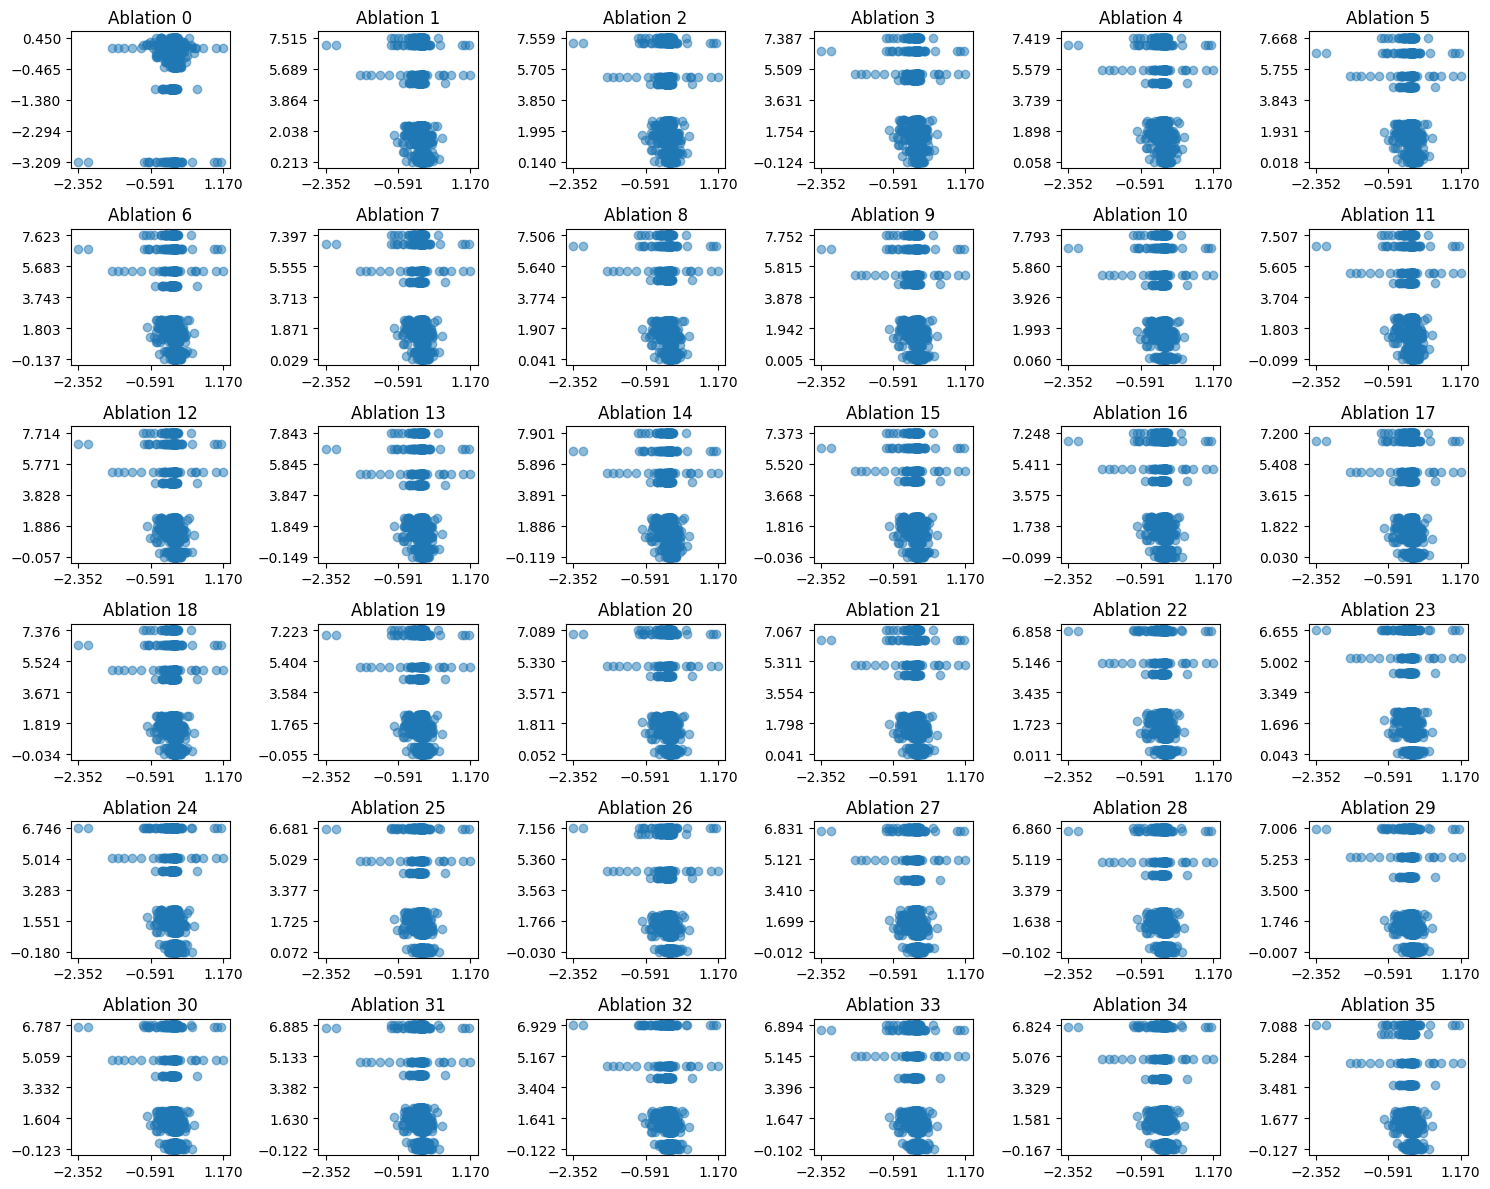

In [230]:
plot_compensatory_response_vs_direct_effect(results, target_logit=False, contribution="all")